### Exercise 2 Semi Supervised Learning

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import numpy as np
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score
import matplotlib.pyplot as plt



# if gpu available, use gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
# is cuda available
print("Cuda available: ", torch.cuda.is_available())

Cuda available:  True


Damit das Notebook ausgeführt werden kann müssen die Ordner test_set und training_set aus der ursprünglichen zip datei in einen ordner mit dem Namen "labeled_img" gelegt werden.

In [2]:
# load the data
img_dir = 'labeled_img/'
train_cats_dir = os.path.join(img_dir, 'training_set/cats')
train_dogs_dir = os.path.join(img_dir, 'training_set/dogs')
test_cats_dir = os.path.join(img_dir, 'test_set/cats')
test_dogs_dir = os.path.join(img_dir, 'test_set/dogs')

def load_images_and_labels(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            img = img.resize((224, 224))  # Resize images to 224x224
            img = np.array(img)  # Convert to NumPy array
            if img is not None:
                images.append(img)
                labels.append(label)  # Add the corresponding label
    return np.array(images), np.array(labels)

train_cats, labels_cats = load_images_and_labels(train_cats_dir, 0)  # 0 for cats
train_dogs, labels_dogs = load_images_and_labels(train_dogs_dir, 1)  # 1 for dogs

train_images = np.concatenate([train_cats, train_dogs])
train_labels = np.concatenate([labels_cats, labels_dogs])

test_cats, labels_cats = load_images_and_labels(test_cats_dir, 0)  # 0 for cats
test_dogs, labels_dogs = load_images_and_labels(test_dogs_dir, 1)  # 1 for dogs

test_images = np.concatenate([test_cats, test_dogs])
test_labels = np.concatenate([labels_cats, labels_dogs])

# create "labeled" and "unlabeled" data
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42) # X_val und y_val sind die Validierungsdaten
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)  # 10% labeled, 90% unlabeled

So wie in der Angabe vorgeschlagen, werden nach einem initialen train_test_split von 80/20 die Trainingsdaten weiter gesplittet in 10% gelabelte Daten und 90% ungelabelt.

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = np.array(image, dtype=np.uint8)  # Konvertierung zu uint8, falls nötig

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.labels = np.zeros((len(images), 1)) # Hinzufügen einer leeren Spalte für die Labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = np.array(image, dtype=np.uint8)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
train_transform = transforms.Compose([
    transforms.RandomRotation(40), 
    transforms.RandomResizedCrop(224), 
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validation_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_labeled, y_labeled, train_transform)
test_dataset = CustomDataset(X_unlabeled, _ , test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

labeled_dataset = CustomDataset(X_labeled, y_labeled, train_transform)
val_dataset = CustomDataset(X_val, y_val, test_transform)
#unlabeled_dataset = CustomDataset(X_unlabeled, np.zeros(len(X_unlabeled)), train_transform)
unlabeled_dataset = UnlabeledDataset(X_unlabeled, transform=train_transform)  

labeled_loader = torch.utils.data.DataLoader(labeled_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
#unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=32, shuffle=True)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)

# print size of labeled_dataset, val_dataset, unlabeled_dataset
print("Size of labeled_dataset: ", len(labeled_dataset))
print("Size of val_dataset: ", len(val_dataset))
print("Size of unlabeled_dataset: ", len(unlabeled_dataset))

# print size of labeled_loader, val_loader, unlabeled_loader
print("Size of labeled_loader: ", len(labeled_loader))
print("Size of val_loader: ", len(val_loader))
print("Size of unlabeled_loader: ", len(unlabeled_loader))

Size of labeled_dataset:  640
Size of val_dataset:  1600
Size of unlabeled_dataset:  5760
Size of labeled_loader:  20
Size of val_loader:  50
Size of unlabeled_loader:  180


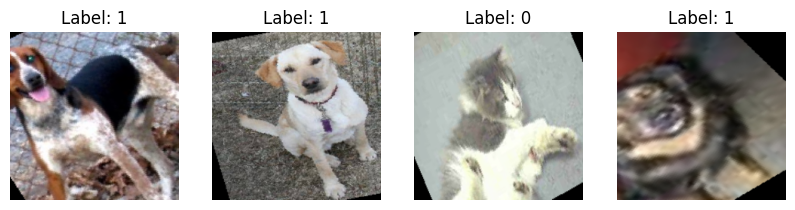

In [79]:
import matplotlib.pyplot as plt

# Funktion zur Visualisierung von Bildern und Labels
def show_images(images, labels, num_images=4):
    fig, axs = plt.subplots(1, num_images, figsize=(10, 5))
    for i in range(num_images):
        img = images[i].numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # denormalize
        img = np.clip(img, 0, 1)
        axs[i].imshow(img)
        axs[i].set_title(f'Label: {labels[i]}')
        axs[i].axis('off')
    plt.show()

# Laden der ersten zwei Bilder und Labels aus dem DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Aufrufen der Funktion zur Visualisierung
show_images(images, labels)


Das Modell EnhancedCNN ist eine tiefergehende Variante eines konvolutionellen neuronalen Netzes, das speziell für die Verarbeitung von Bildern entworfen wurde. Es besteht aus vier konvolutionellen Schichten, die jeweils von ReLU-Aktivierungsfunktionen und Max-Pooling gefolgt werden, was die räumlichen Dimensionen reduziert und die wichtigsten Merkmale extrahiert. Nach den konvolutionellen Schichten wird der Datenfluss durch zwei vollverbundene Schichten geleitet, die durch Dropout-Schichten ergänzt werden, um Overfitting zu vermeiden. Dieses Netzwerk ist darauf ausgelegt, aus großen Bildern durch sukzessive Filterung hochkomplexe Features zu lernen.

In [63]:

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2)
        # Anpassen der folgenden Dimensionen entsprechend der Größe des Output-Feature-Maps
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.act5 = nn.ReLU()
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 128)
        self.act6 = nn.ReLU()
        self.drop2 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.drop1(self.act5(self.fc1(x)))
        x = self.drop2(self.act6(self.fc2(x)))
        x = self.fc3(x)
        return x


In [64]:
learning_rate = 0.0005  # Höhere Lernrate für ein neues Modell
weight_decay = 0.005  # Geringerer Weight Decay

#model = SimpleCNN()
model = EnhancedCNN()
#model = models.vgg16(pretrained=False)
#model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)  # Ersetze den letzten Layer


model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
criterion = nn.BCEWithLogitsLoss()


#### "Labeled" Training
* Optimizer und Learning Rate: Wir verwenden den Adam-Optimizer mit einer initialen Lernrate von 0.0005. Diese Wahl beruht darauf, dass Adam automatisch die Lernraten anpasst, was hilft, effizientere und stabilere Updates der Gewichte während des Trainings zu erreichen.

* Weight Decay: Ein Weight Decay von 0.005 ist integriert, um die Komplexität des Modells zu regulieren. Dies fördert kleinere Gewichtswerte, wodurch das Risiko von Overfitting gemindert wird, indem die Generalisierungsfähigkeit des Modells verbessert wird.

* Learning Rate Scheduler: Der ReduceLROnPlateau-Scheduler passt die Lernrate dynamisch an, basierend auf der Entwicklung des Validierungsverlusts. Wenn keine Verbesserung des Verlusts über fünf Epochen hinweg festgestellt wird, reduziert der Scheduler die Lernrate um den Faktor 0.1. Dies hilft, aus lokalen Minima herauszukommen und verbessert potenziell die Konvergenz des Modells.

* Loss Function: Die Verwendung von BCEWithLogitsLoss ist ideal für binäre Klassifikationsaufgaben und kombiniert eine Sigmoid-Aktivierung mit einem binären Kreuzentropieverlust in einer einzigen Klasse, was numerische Stabilität während des Trainings bietet.

* Batch-Verarbeitung und Normalisierung: Jede Epoche verarbeitet Bilder in Batches, wobei jedes Bild vor der Eingabe ins Modell normalisiert wird. Dies stellt sicher, dass das Modell nicht von Variationen in der Bildskalierung beeinflusst wird.

* Early Stopping: Um effizient zu sein und Overfitting weiter zu vermeiden, implementiert der Trainingsprozess eine Early-Stopping-Logik. Wenn der Validierungsverlust für eine festgelegte Anzahl von Epochen (hier 10) nicht mehr verbessert wird, wird das Training vorzeitig abgebrochen. Dies stellt sicher, dass das Modell nicht auf den Trainingsdaten überlernt, indem das Training gestoppt wird, sobald keine signifikanten Verbesserungen mehr erzielt werden.
Trainings- und Validierungsdurchläufe: Während des Trainings wird die Genauigkeit auf dem Trainingsset gemessen und der Verlust sowohl für das Trainings- als auch für das Validierungsset berechnet und aufgezeichnet. Diese Metriken helfen, die Leistung des Modells während des Trainings zu überwachen und die Anpassungen des Modells gemäß der Leistung auf nicht gesehenen Daten zu bewerten.

In [65]:
# training des modells

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_num = 100
best_val_loss = float('inf')
patience = 10 
wait = 0  # Zähler, um zu sehen, wie lange kein neues Minimum erreicht wurde

for epoch in range(epoch_num):
    model.train()
    correct_train = 0
    total_train = 0
    for images, labels in labeled_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        
        # Berechnung der Trainingsgenauigkeit
        predicted = torch.sigmoid(outputs.squeeze()).round()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    scheduler.step(loss)    
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Training Accuracy: {train_accuracy}%')

    # Validierungsverlust und -genauigkeit berechnen
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()
            
            # Berechnung der Validierungsgenauigkeit
            predicted = torch.sigmoid(outputs.squeeze()).round()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%')

    # Early Stopping Logik
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping after {epoch + 1} epochs')
            break


Epoch 1, Loss: 0.6904610395431519, Training Accuracy: 49.375%
Epoch 1, Validation Loss: 0.6932190430164337, Validation Accuracy: 49.75%
Epoch 2, Loss: 0.6947516798973083, Training Accuracy: 48.90625%
Epoch 2, Validation Loss: 0.6925397050380707, Validation Accuracy: 49.75%
Epoch 3, Loss: 0.6973308324813843, Training Accuracy: 48.125%
Epoch 3, Validation Loss: 0.6940139365196228, Validation Accuracy: 49.75%
Epoch 4, Loss: 0.6989072561264038, Training Accuracy: 48.90625%
Epoch 4, Validation Loss: 0.6936561131477356, Validation Accuracy: 49.75%
Epoch 5, Loss: 0.6907020807266235, Training Accuracy: 49.21875%
Epoch 5, Validation Loss: 0.6930218124389649, Validation Accuracy: 50.25%
Epoch 6, Loss: 0.6945764422416687, Training Accuracy: 49.0625%
Epoch 6, Validation Loss: 0.6935785233974456, Validation Accuracy: 49.75%
Epoch 7, Loss: 0.6912757754325867, Training Accuracy: 48.90625%
Epoch 7, Validation Loss: 0.6933748126029968, Validation Accuracy: 49.75%
Epoch 8, Loss: 0.6925267577171326, Trai

Es war natürlich anzunehmen, dass das Modell auf Basis der stark eingeschränkten Trainingsdaten nicht allzu gut lernen wird. Einige wichtige Beobachtungen:
* Startperformance: Zu Beginn des Trainings liegen die Training- und Validierungsgenauigkeit nahe bei 50%, was nahelegt, dass das Modell zu diesem Zeitpunkt kaum besser als Zufall klassifiziert. Dies ist typisch für frühe Phasen des Trainings, insbesondere bei komplexeren Modellen und Datensätzen.
* Stagnation der Genauigkeit: Sowohl die Trainings- als auch die Validierungsgenauigkeit zeigen geringe Verbesserungen und verharren um den Wert von 55%, was darauf hindeutet, dass das Modell Schwierigkeiten hat, aus den bereitgestellten Daten effektiv zu lernen und sich signifikant zu verbessern.
* Loss-Werte: Die Loss-Werte für Training und Validierung beginnen hoch und zeigen eine allmähliche, aber inkonsistente Verbesserung. Diese schrittweise Verringerung des Loss deutet darauf hin, dass das Modell mit jeder Epoche besser wird, jedoch nicht ausreichend, um eine signifikante Steigerung der Genauigkeit zu erreichen.
* Geringe Fortschritte: Die leichten Fortschritte in den späteren Epochen, wo der Validierungsverlust langsam aber stetig abnimmt, deuten darauf hin, dass das Modell beginnt, Muster in den Daten zu erkennen, aber möglicherweise zu langsam lernt, um effektive Generalisierungen innerhalb des gegebenen Rahmens von 100 Epochen zu machen.
* Early Stopping: Trotz der Implementierung eines Early Stopping-Mechanismus, der das Training stoppen soll, wenn sich die Validierungsverluste nicht verbessern, zeigt der Output, dass das Modell bis zu 100 Epochen durchläuft. Dies könnte darauf hindeuten, dass die Einstellungen für das Early Stopping (wie die Patience) möglicherweise angepasst werden müssen, um eine effektivere Trainingskontrolle zu ermöglichen. Definitiv eines der Details die ich genauer betrachten würde, wenn mir nicht mittlerweile die Zeit davonlaufen würde.

In [66]:
# save the model
torch.save(model.state_dict(), 'final_baseline_model.pth')

In [70]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

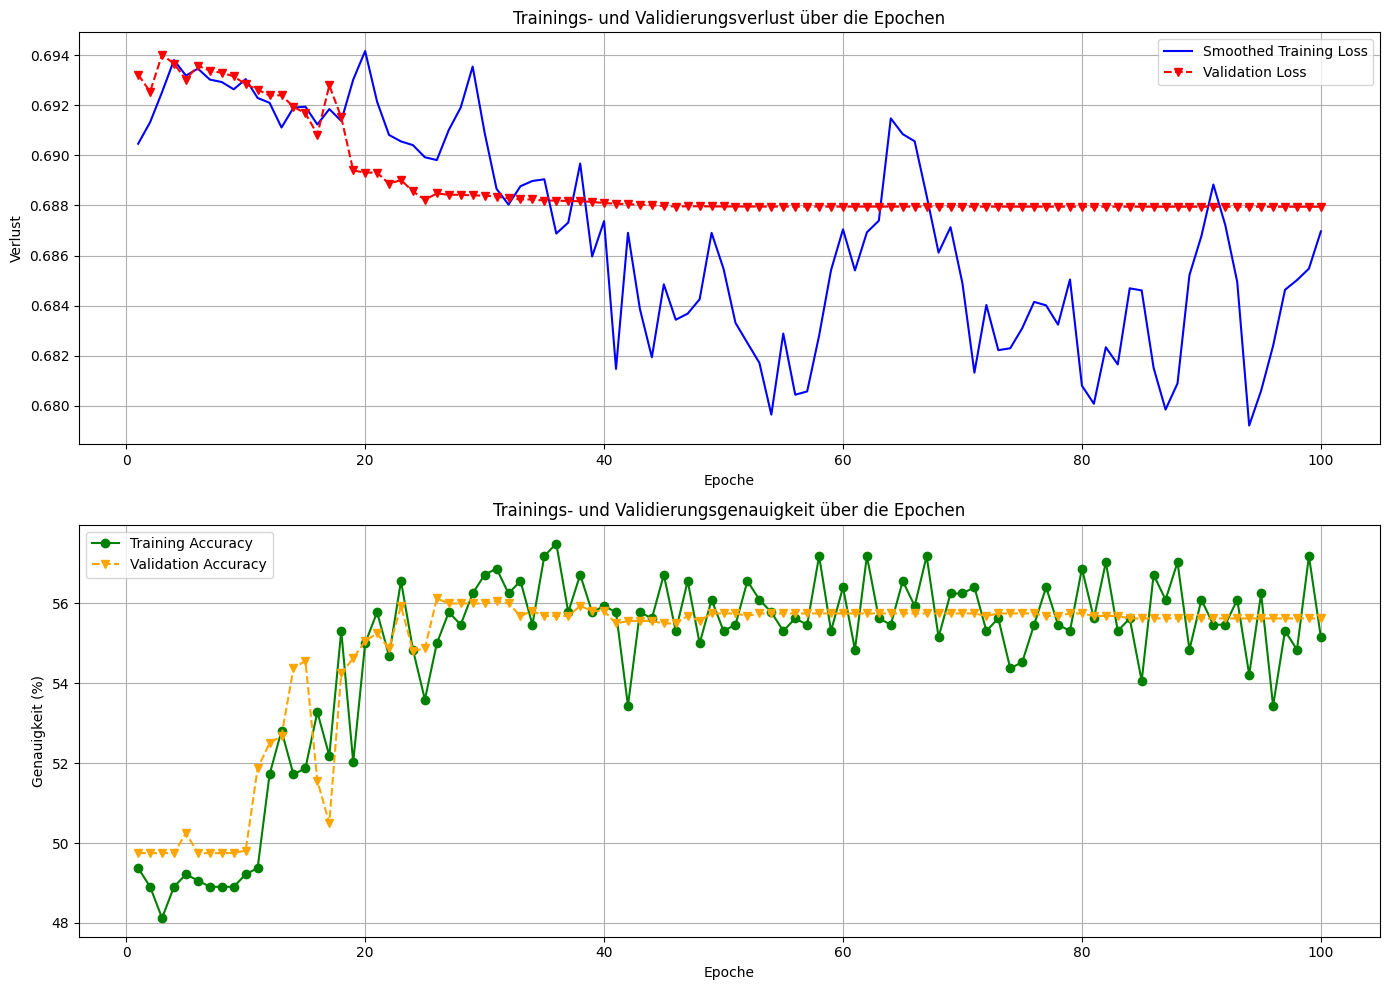

In [72]:
# visualize the training progress
plt.figure(figsize=(14, 10))

# Anzahl der Epochen ermitteln
epochs = range(1, len(train_losses) + 1)

plt.subplot(2, 1, 1)  # Erster Subplot für die Verluste
# Anzeigen der Original Trainingsverluste
#plt.plot(epochs, train_losses, marker='o', linestyle='-', color='blue', label='Training Loss')
# Anzeigen der geglätteten Trainingsverluste
smoothed_train_losses = smooth_curve(train_losses)
plt.plot(epochs, smoothed_train_losses, linestyle='-', color='blue', label='Smoothed Training Loss')
# Anzeigen der Validierungsverluste
plt.plot(epochs, val_losses, marker='v', linestyle='--', color='red', label='Validation Loss')
plt.title('Trainings- und Validierungsverlust über die Epochen')
plt.xlabel('Epoche')
plt.ylabel('Verlust')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)  # Zweiter Subplot für die Genauigkeiten
plt.plot(epochs, train_accuracies, marker='o', linestyle='-', color='green', label='Training Accuracy')
plt.plot(epochs, val_accuracies, marker='v', linestyle='--', color='orange', label='Validation Accuracy')
plt.title('Trainings- und Validierungsgenauigkeit über die Epochen')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Es gibt einige kleine Schwankungen in der Genauigkeit und im Verlust, die möglicherweise auf die Variabilität in den Trainingsdaten oder auf die Limitationen des Modells zurückzuführen sind. Das frühe Anhalten nach 24 Epochen wegen mangelnder Verbesserung ist ebenfalls ein interessanter Punkt, der darauf hindeutet, dass das Modell möglicherweise ein Plateau erreicht hat.

Warum die dynamische Anpassung der Lernrate nutzen?
Effizientere Konvergenz: Indem man die Lernrate zu Beginn höher einstellt, kann das Modell schneller große Gradienten überwinden und in eine allgemeine Nähe des globalen Minimums gelangen. Nach einer bestimmten Anzahl von Epochen oder wenn das Modell Anzeichen einer Stabilisierung zeigt, kann die Lernrate verringert werden, um eine feinere Anpassung zu ermöglichen und Überanpassungen zu vermeiden.
Vermeidung von Plateaus: Bei konstanter Lernrate kann das Modell in einem Plateau stecken bleiben, wo keine Verbesserung der Leistung festgestellt wird. Eine angepasste Lernrate kann das Modell aus solchen Plateaus herausholen.

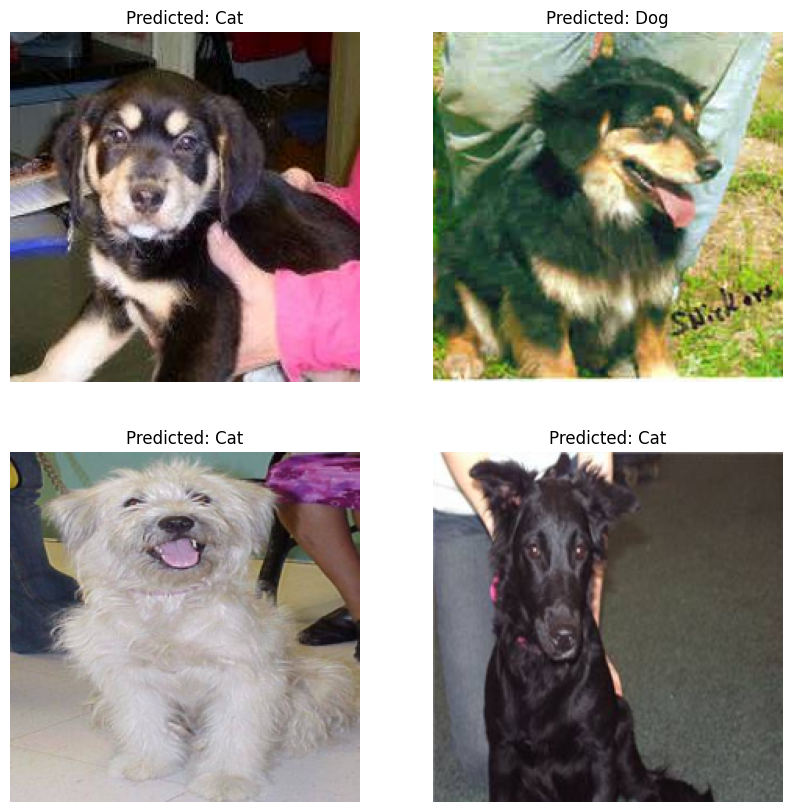

In [87]:
import random

def visualize_random_model_predictions(model, data_loader, num_images=4):
    model.eval()  # Setze das Modell auf Evaluation-Modus
    images_handled = 0
    plt.figure(figsize=(10, 10))

    data_iter = iter(data_loader)
    # Berechne, wie viele Batches vorhanden sind
    total_batches = len(data_loader)
    
    # Zufällige Auswahl von Batches
    random_batches = random.sample(range(total_batches), k=min(4, total_batches))  # Wähle bis zu 5 zufällige Batches
    
    with torch.no_grad():
        for batch_index in random_batches:
            # Springe zu zufälligem Batch
            for _ in range(batch_index):
                next(data_iter)
            
            images, labels = next(data_iter)
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).round()  # Runde die Sigmoid-Ausgabe zum Klassifizieren

            for j in range(images.size()[0]):
                if images_handled >= num_images:
                    plt.show()
                    return
                ax = plt.subplot(num_images//2, 2, images_handled + 1)
                ax.axis('off')
                ax.set_title(f'Predicted: {"Dog" if preds[j] > 0.5 else "Cat"}')
                img = images[j].cpu().data.numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                images_handled += 1

# Rufe die Funktion auf, um Vorhersagen zu visualisieren
visualize_random_model_predictions(model, test_loader)


Die Methode self_train zielt darauf ab, unser CNN iterativ durch die schrittweise Integration von hochkonfidenten, ungelabelten Daten zu verbessern. In jeder Iteration evaluiert das Modell einen Satz ungelabelter Daten und identifiziert diejenigen, bei denen es sich am sichersten ist – basierend auf einer dynamisch angepassten Konfidenzschwelle. Diese ausgewählten Daten werden dann den gelabelten Trainingsdaten hinzugefügt, um das Modell erneut zu trainieren, wobei die Hoffnung besteht, dass das Modell durch das Lernen von mehr und vielfältigeren Daten genauer wird.

In [92]:
def self_train(model, unlabeled_loader, labeled_loader, optimizer, criterion, device, evaluator, max_iterations=10):
    previous_accuracy = 0
    confidence_threshold = 0.05

    for iteration in range(max_iterations):
        model.eval()
        samples = []
        confidences = []
        train_losses = []

        with torch.no_grad():
            for images, _ in unlabeled_loader:
                images = images.to(device)
                outputs = torch.sigmoid(model(images)).squeeze()
                conf = torch.abs(outputs - 0.5)
                samples.extend(zip(images.cpu().numpy(), outputs.cpu().numpy(), conf.cpu().numpy()))

        # Dynamische Anpassung der Schwelle basierend auf der vorherigen Genauigkeit
        if iteration > 0 and previous_accuracy > 0:
            performance_change = (accuracy - previous_accuracy) / previous_accuracy
            if performance_change > 0.01:  # Leistungsverbesserung um mehr als 1%
                confidence_threshold = min(confidence_threshold + 0.01, 0.15)  # Erhöhe die Schwelle, max 15%
            elif performance_change < -0.01:  # Leistungsverschlechterung um mehr als 1%
                confidence_threshold = max(confidence_threshold - 0.01, 0.05)  # Senke die Schwelle, min 5%
            # diese schwellenwerte habe ich anhand der erfahrung mit durchläufen in denen der schwellenwert statisch war gewählt

        samples.sort(key=lambda x: x[2], reverse=True)
        cutoff_index = int(confidence_threshold * len(samples))
        top_samples = samples[:cutoff_index] # to get the dynamically determined top % of the batch

        high_confidence_images = np.array([x[0] for x in top_samples])
        high_confidence_labels = np.array([(x[1] > 0.5).astype(int) for x in top_samples])

        if len(high_confidence_images) == 0:
            print("No high confidence images to add, stopping training.")       
            break

        new_train_images = np.concatenate([X_labeled, high_confidence_images.reshape(-1, 224, 224, 3)])
        new_train_labels = np.concatenate([y_labeled, high_confidence_labels])
        new_train_dataset = CustomDataset(new_train_images, new_train_labels, transform=train_transform)
        labeled_loader = DataLoader(new_train_dataset, batch_size=32, shuffle=True)

        model.train()
        total_loss = 0
        for images, labels in labeled_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(labeled_loader)
        train_losses.append(avg_train_loss)

        avg_loss, accuracy = evaluator.evaluate(model, criterion)
        print(f'Iteration {iteration + 1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_loss}, Accuracy: {accuracy}')

        #scheduler.step(avg_loss)


        # Convergence check
        #if abs(previous_accuracy - accuracy) < 0.00005:  # Schwellenwert für Konvergenz
        #    print("Model has converged.")
        #    break
        previous_accuracy = accuracy

    return model


Convergence Check - war mein erster Versuch eine cut off bedingung einzubauen. Der ursprünglich in der self_train Methode eingebaute "Convergence Check" sollte dazu dienen, das Training frühzeitig zu beenden, wenn keine signifikanten Verbesserungen in der Modellgenauigkeit zwischen den Iterationen mehr feststellbar waren. Der Gedanke dahinter war, Rechenressourcen zu sparen und Overfitting zu vermeiden, indem das Training abgebrochen wird, sobald das Modell eine Konvergenz erreicht hat, also keine messbaren Fortschritte mehr macht. Nachdem ich es leider in keinem meiner Versuche geschafft habe mit der self_train methode fortschritte zu erzielen, habe ich den convergence check jetzt nicht verwendet.


Anstelle des cutoff_index der in der jetzigen Version vorhanden ist mit dem eine dynamische Anpassung der Schwelle für top_samples bestimmt wird, habe ich zuerst noch mit einem statischem Prozentsatz die "sichersten" Einträge aus top_samples genommen. Dabei habe ich verschiedene Werte für den Prozentsatz durchprobiert und folgendes gefunden:

* Niedriger Schwellenwert (5%): Ein konservativer Ansatz, der darauf abzielt, nur die sichersten Prognosen hinzuzufügen. Dies führte zu einem Anstieg des Trainingsverlusts ohne wesentliche Verbesserung der Genauigkeit, was darauf hindeutet, dass zu wenige Daten hinzugefügt wurden, um einen signifikanten Lerneffekt zu erzielen.
* Mittlerer Schwellenwert (10%): Bei diesem Schwellenwert haben wir eine moderate Anzahl von Samples hinzugefügt. Die Ergebnisse zeigten eine leichte Verbesserung in der Genauigkeit, jedoch waren die Trainingsergebnisse im Verlauf der Iterationen noch instabil, was auf eine potenziell optimierbare Balance zwischen neuen und vorhandenen Daten hindeutet.
* Hoher Schwellenwert (20%): Dieser liberale Ansatz führte zu einer stärkeren Integration von ungelabelten Daten. Es zeigte sich jedoch, dass der Training Loss erhöht wurde und die Genauigkeit stagnierte. Dies könnte auf die Hinzufügung weniger zuverlässiger Daten hinweisen, die das Modell verwirren und es von der Generalisierung abhalten könnten.

Confidence Threshold: Der dynamische Ansatz unserer self_train Methode passt die Konfidenzschwelle (confidence_threshold) und damit den cutoff_index für die Auswahl hochvertrauenswürdiger ungelabelter Samples iterativ an. Dies geschieht basierend auf den Veränderungen der Modellgenauigkeit von einer Iteration zur nächsten. Bei einer Verbesserung der Genauigkeit um mehr als 1% wird die Schwelle erhöht, was eine breitere Integration neuer Daten ermöglicht. Verschlechtert sich die Genauigkeit hingegen um mehr als 1%, wird die Schwelle gesenkt, um das Risiko falscher Labels zu minimieren. Dieser flexible Ansatz ermöglicht eine feinere Anpassung des Lernprozesses und zielt darauf ab, das Gleichgewicht zwischen dem Erkennen neuer Muster und der Vermeidung der Integration fehlerhafter Daten zu optimieren.

#### ModelEvaluator
Der ModelEvaluator ist eine Hilfsklasse, die entwickelt wurde, um die Leistung des Modells während des Trainingsprozesses systematisch zu überwachen und zu bewerten. Er ermöglicht es uns, den durchschnittlichen Verlust und die Genauigkeit des Modells auf einem Validierungsdatensatz zu berechnen und aufzuzeichnen. Diese Evaluierungen unterstützen eine objektive Beurteilung des Modells in Bezug auf seine Generalisierungsfähigkeit und helfen dabei, Überanpassung (Overfitting) zu vermeiden. Durch die Bereitstellung von Feedback über Modellleistung nach jeder Iteration oder Epoche, kann der ModelEvaluator auch zur Entscheidungsfindung bei der Anpassung von Modellparametern und beim frühzeitigen Abbruch des Trainings verwendet werden.

In [74]:
class ModelEvaluator:
    def __init__(self, loader, device):
        self.loader = loader
        self.device = device
        self.history = []
    
    def evaluate(self, model, criterion):
        model.eval()
        val_loss = 0
        total = 0
        correct = 0
        
        with torch.no_grad():
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item() * images.size(0)
                predicted = torch.sigmoid(outputs).round()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_loss = val_loss / total
        accuracy = (correct / total)/100
        self.history.append((avg_loss, accuracy))
        return avg_loss, accuracy
    

In [93]:
# instantiate evaluator and train model
evaluator = ModelEvaluator(val_loader, device)
model = self_train(model, unlabeled_loader, labeled_loader, optimizer, criterion, device, evaluator)

Iteration 1: Training Loss: 0.6896658724751966, Validation Loss: 0.6878869962692261, Accuracy: 0.1612375
Iteration 2: Training Loss: 0.689812471126688, Validation Loss: 0.6878853476047516, Accuracy: 0.1612375
Iteration 3: Training Loss: 0.6912175786906275, Validation Loss: 0.6878842806816101, Accuracy: 0.1612375
Iteration 4: Training Loss: 0.6910157306440945, Validation Loss: 0.6878830695152283, Accuracy: 0.1612375
Iteration 5: Training Loss: 0.6901911291582831, Validation Loss: 0.6878816461563111, Accuracy: 0.161275
Iteration 6: Training Loss: 0.6913646603452748, Validation Loss: 0.6878804361820221, Accuracy: 0.161275
Iteration 7: Training Loss: 0.6902805772320978, Validation Loss: 0.6878789353370667, Accuracy: 0.161275
Iteration 8: Training Loss: 0.6895668999902134, Validation Loss: 0.6878776276111602, Accuracy: 0.1612875
Iteration 9: Training Loss: 0.6897043935183821, Validation Loss: 0.6878762769699097, Accuracy: 0.16126249999999998
Iteration 10: Training Loss: 0.689908309229489, V

Der Output des Self-Train-Trainings über zehn Iterationen zeigt geringfügige, aber stetige Verringerungen sowohl im Trainingsverlust als auch im Validierungsverlust. Die Genauigkeitswerte bleiben jedoch weitgehend unverändert und deuten darauf hin, dass das Modell keine effektiven Lernfortschritte macht. Diese marginalen Verbesserungen im Loss könnten auf die geringe Variabilität und möglicherweise geringe Qualität der hinzugefügten hochvertrauenswürdigen Samples zurückzuführen sein. Die Stagnation der Genauigkeit unterstreicht die Notwendigkeit einer Überarbeitung des Ansatzes, um das Modell effektiver zu trainieren und die Erkennung von Mustern in den ungelabelten Daten zu verbessern.

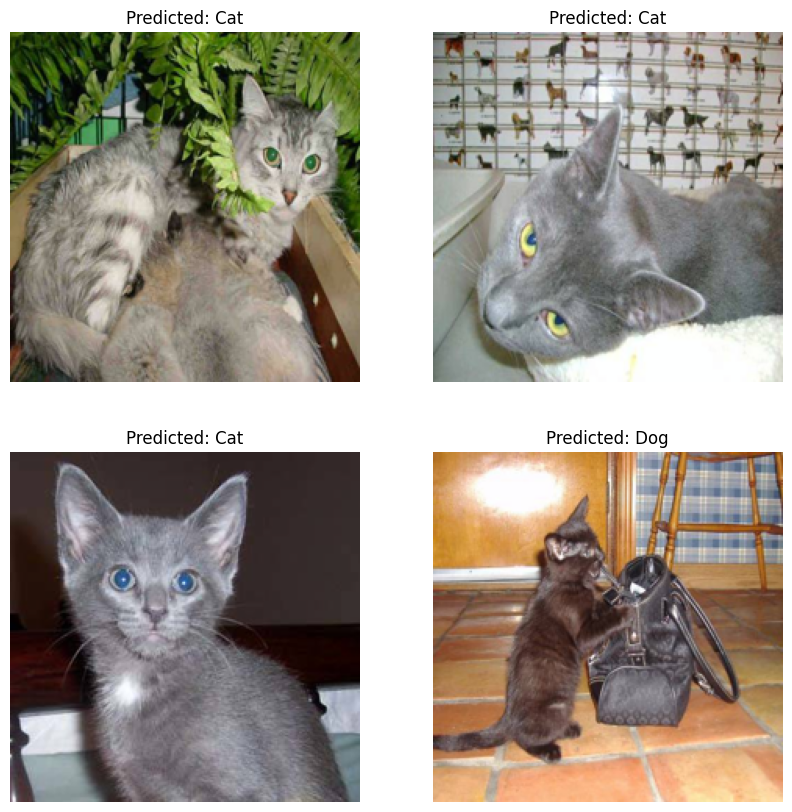

In [94]:
visualize_random_model_predictions(model, test_loader)

output mit top 5% pro batch (zu konservativ)
* Iteration 1: Training Loss: 0.454335132549549, Validation Loss: 0.7189883232116699, Accuracy: 0.1606
* Iteration 2: Training Loss: 0.4525300356848487, Validation Loss: 0.7189827632904052, Accuracy: 0.1606
* Iteration 3: Training Loss: 0.4596765246884576, Validation Loss: 0.7189837223291398, Accuracy: 0.1606
* Iteration 4: Training Loss: 0.46665568495618887, Validation Loss: 0.7189774096012116, Accuracy: 0.1606
* Iteration 5: Training Loss: 0.45297194863187856, Validation Loss: 0.7189766520261764, Accuracy: 0.1606
* Iteration 6: Training Loss: 0.45345787447074365, Validation Loss: 0.7189741176366806, Accuracy: 0.1606
* Iteration 7: Training Loss: 0.4672443322066603, Validation Loss: 0.7189644777774811, Accuracy: 0.1606
* Iteration 8: Training Loss: 0.4574616911082432, Validation Loss: 0.7189574062824249, Accuracy: 0.160625
* Iteration 9: Training Loss: 0.46777396983113784, Validation Loss: 0.7189538663625717, Accuracy: 0.160625
* Iteration 10: Training Loss: 0.46181937127277767, Validation Loss: 0.7189417034387589, Accuracy: 0.160625

output mit top 10% pro batch

* Iteration 1: Training Loss: 0.3774138673355705, Validation Loss: 0.7116830676794053, Accuracy: 0.1612
* Iteration 2: Training Loss: 0.3723115383794433, Validation Loss: 0.7196561223268509, Accuracy: 0.1611125
* Iteration 3: Training Loss: 0.36073474115446996, Validation Loss: 0.7300827813148498, Accuracy: 0.16076250000000003
* Iteration 4: Training Loss: 0.36908904972829315, Validation Loss: 0.7306138491630554, Accuracy: 0.1608375
* Iteration 5: Training Loss: 0.36172701496826976, Validation Loss: 0.7278795373439789, Accuracy: 0.160725
* Iteration 6: Training Loss: 0.3652651760923235, Validation Loss: 0.7273554682731629, Accuracy: 0.1608375
* Iteration 7: Training Loss: 0.3564566773803611, Validation Loss: 0.7273034131526948, Accuracy: 0.160925
* Iteration 8: Training Loss: 0.35960355008903305, Validation Loss: 0.726562219262123, Accuracy: 0.1609
* Iteration 9: Training Loss: 0.35614859783335734, Validation Loss: 0.7272424441576004, Accuracy: 0.1609375
* Iteration 10: Training Loss: 0.3648917627962012, Validation Loss: 0.726982725262642, Accuracy: 0.16091249999999999

output mit top 20% pro batch (zu liberal)
* Iteration 1: Training Loss: 0.35399381816387177, Validation Loss: 0.7225587058067322, Accuracy: 0.160625
* Iteration 2: Training Loss: 0.3971105406859091, Validation Loss: 0.7218890589475632, Accuracy: 0.16061250000000002
* Iteration 3: Training Loss: 0.39952027212296215, Validation Loss: 0.7211397433280945, Accuracy: 0.1605375
* Iteration 4: Training Loss: 0.3767327990915094, Validation Loss: 0.7205519437789917, Accuracy: 0.1605875
* Iteration 5: Training Loss: 0.37055555544793606, Validation Loss: 0.7201704984903335, Accuracy: 0.1605875
* Iteration 6: Training Loss: 0.3869973248136895, Validation Loss: 0.7196955025196076, Accuracy: 0.1606
* Iteration 7: Training Loss: 0.4001218524894544, Validation Loss: 0.7191482841968536, Accuracy: 0.1606
* Iteration 8: Training Loss: 0.3825598747602531, Validation Loss: 0.7190980803966522, Accuracy: 0.1606
* Iteration 9: Training Loss: 0.382450294015663, Validation Loss: 0.7190571236610412, Accuracy: 0.1606
* Iteration 10: Training Loss: 0.40491060885999886, Validation Loss: 0.7190148681402206, Accuracy: 0.1606

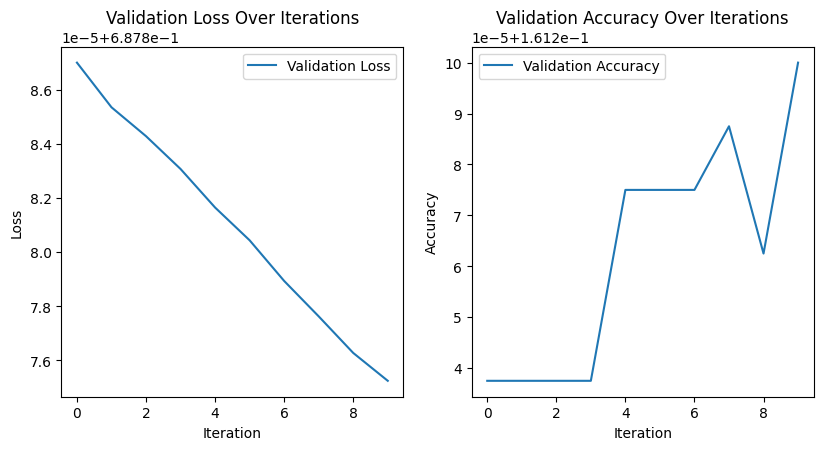

In [95]:
losses, accuracies = zip(*evaluator.history)

plt.figure(figsize=(15, 10))

# Plot für Validation Loss
plt.subplot(2, 3, 1)
plt.plot(losses, label='Validation Loss')
plt.title('Validation Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

# Plot für Validation Accuracy
plt.subplot(2, 3, 2)
plt.plot(accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [98]:
test_dataset = CustomDataset(test_images, test_labels, test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


def evaluate_model(model, test_loader, device, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            test_loss += loss.item()
            predicted = torch.sigmoid(outputs).round()  # Sigmoid, da Binary Classification
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = test_loss / len(test_loader)
    return average_loss, accuracy



# Berechnung der Testgenauigkeit und des Verlusts
test_loss, test_accuracy = evaluate_model(model, test_loader, device, criterion)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.6880, Test Accuracy: 18.28%


### Ergebnisse des Trainings


#### Labeled Training:
* Training Loss: 0.6929
* Training Accuracy: 55.16%
* Validation Loss: 0.6879
* Validation Accuracy: 55.63%

#### Self-Training:
* Training Loss: 0.6899
* Validation Loss: 0.6879
* Accuracy: 0.1613

#### Test Evaluation
* Test Loss: 0.6880
* Test Accuracy: 18.28%

#### Interpretation und Vergleich
<strong>Vergleich der Effektivität:</strong>

Das Modell, das nur mit initial gelabelten Daten trainiert wurde, erreicht auf dem Validierungsset eine Genauigkeit von etwa 55.63% und einen Verlust von 0.6879. Im Vergleich dazu ist das durch Self-Training verbesserte Modell auf dem Testset mit einer Genauigkeit von nur 18.28% signifikant schlechter. Der Testverlust ist mit 0.6880 etwas höher als der Validierungsverlust des gelabelten Trainings, was darauf hindeutet, dass das Modell nicht gut generalisiert und potenziell überangepasst sein könnte, trotz des Versuchs, mehr Daten durch semi-supervised Learning zu integrieren.

<strong>Diskussion der Self-Training-Effektivität:</strong>

Die geringe Genauigkeit von nur 0.1613 im finalen Self-Training zeigt, dass dieses spezifische Modell und der Ansatz mit den gewählten Parametern und Daten nicht effektiv waren. Die dynamische Anpassung des Konfidenzschwellenwerts und das Hinzufügen von ungelabelten Daten scheinen nicht zu einer Verbesserung der Modellleistung geführt zu haben. Stattdessen hat es das Modell möglicherweise mit nicht ausreichend präzisen oder irrelevanten Informationen überladen, was zu einer Verschlechterung der Modellleistung auf neuen, unbekannten Daten geführt hat.

<strong>Mögliche Gründe für geringe Performance:</strong>

* Die verwendeten ungelabelten Daten könnten eine schlechte Qualität aufweisen oder nicht repräsentativ für die Aufgabenstellung sein. Dies kann zu einer Fehlanpassung des Modells führen.
* Der semi-supervised Ansatz benötigt möglicherweise eine präzisere Handhabung und Optimierung der Hyperparameter sowie eine bessere Strategie zur Datenqualitätssicherung und -auswahl.
* Die geringe Anzahl an initial gelabelten Daten kann das Modell daran hindern, robuste, generalisierbare Muster zu lernen, was durch die ungenauen oder unzuverlässigen Labels der hinzugefügten ungelabelten Daten verstärkt wird.

<strong>Schlussfolgerung:</strong>

Das semi-supervised Learning mit Self-Training zeigte in diesem spezifischen Fall keine effektive Verbesserung der Modellleistung. Die niedrige Testgenauigkeit im Vergleich zur höheren Genauigkeit des rein gelabelten Trainings weist darauf hin, dass für dieses spezifische Beispiel ein vollständig supervisierter Ansatz vorzuziehen ist, oder dass eine gründlichere Überprüfung und Anpassung der semi-supervised Learning-Methodik erforderlich ist, um bessere Ergebnisse zu erzielen.
Leider geht mir mittlerweile die Zeit aus, ansonsten wäre eines der Dinge die ich noch ausprobieren würde die Anpassung der Aufteilung in 10% labeled und 90% unlabeled. Obwohl ich nicht glaube, dass meine Probleme self_train() zum Laufen zu kriegen darin begründet sind, wäre es auf jeden Fall leichter mit self learning Fortschritte zu erzielen, wenn eine größere Anzahl an gelabelten Daten für das initale Training vorhanden sind.

Ich vermute, dass mein Notebook ein grundlegenderes Problem hat, das mir nicht aufgefallen ist obwohl oder gerade weil ich sehr viel Zeit mit diesem (und anderen Ansätzen) für Exercise 2 verbracht habe. it is what it is.

¯\\\_(ツ)_/¯
